# Hierarchical DivNoising - Prediction
This notebook contains an example on how to use a previously trained Hierarchical DivNoising model to denoise images.
If you haven't done so please first run '1-CreateNoiseModel.ipynb' and '2-Training.ipynb' notebooks.

In [1]:
# We import all our dependencies.
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import sys
sys.path.append('../../../')

from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training

import os
import glob
import zipfile
import urllib
from tifffile import imread, imsave
from matplotlib import pyplot as plt
from tqdm import tqdm

import cv2

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load noisy test data
The GT test data (```signal```) is created by averaging the noisy images (```observations```).

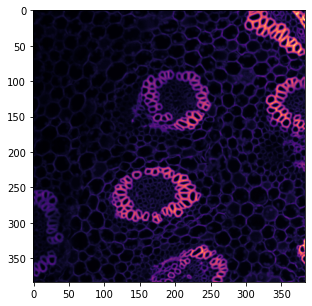

In [3]:
path="./data/Convallaria_diaphragm/"

# The test data is just one quater of the full image ([:,:512,:512]) following the works which have used this data earlier
observation_before= imread(path+'20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif').astype(np.float32)[:,:512,:512]
resize_size = 384
observation = np.zeros((observation_before.shape[0], resize_size, resize_size))
for i in range(observation_before.shape[0]):
    observation[i] = cv2.resize(observation_before[i], (resize_size, resize_size))
signal=np.mean(observation[:,...],axis=0)[np.newaxis,...]
img_width, img_height = signal.shape[1], signal.shape[2]

plt.figure(figsize=(15, 5))
plt.imshow(signal[0],cmap='magma')

# Load our model

In [4]:
%%capture
model = torch.load("./Trained_model/model/convallaria_last_vae.net")
model.mode_pred=True
model.eval()

# Compute PSNR
The higher the PSNR, the better the denoising performance is.
PSNR is computed using the formula: 

```PSNR = 20 * log(rangePSNR) - 10 * log(mse)``` <br> 
where ```mse = mean((gt - img)**2)```, ```gt``` is ground truth image and ```img``` is the prediction from HDN. All logarithms are with base 10.<br>
rangePSNR = max(```gt```)-min(```gt```) for as used in this [paper](https://ieeexplore.ieee.org/abstract/document/9098612/).

In [5]:
gaussian_noise_std = None
num_samples = 100 # number of samples used to compute MMSE estimate
tta = False # turn on test time augmentation when set to True. It may improve performance at the expense of 8x longer prediction time
psnrs = []
range_psnr = np.max(signal[0])-np.min(signal[0])
for i in range(observation.shape[0]):
    img_mmse, samples = boilerplate.predict(observation[i],num_samples,model,gaussian_noise_std,device,tta)
    psnr = utils.PSNR(signal[0], img_mmse, range_psnr)
    psnrs.append(psnr)
    print("image:", i, "PSNR:", psnr, "Mean PSNR:", np.mean(psnrs))

  2%|▏         | 2/100 [00:00<00:06, 16.11it/s]

image: 0 PSNR: 36.37373656978099 Mean PSNR: 36.37373656978099


  2%|▏         | 2/100 [00:00<00:06, 15.99it/s]

image: 1 PSNR: 36.37639198840028 Mean PSNR: 36.37506427909064


  2%|▏         | 2/100 [00:00<00:06, 16.05it/s]

image: 2 PSNR: 36.412658603117805 Mean PSNR: 36.387595720433026


  2%|▏         | 2/100 [00:00<00:06, 15.85it/s]

image: 3 PSNR: 36.70872474040361 Mean PSNR: 36.46787797542567


  2%|▏         | 2/100 [00:00<00:06, 15.74it/s]

image: 4 PSNR: 36.730527557052085 Mean PSNR: 36.520407891750956


  2%|▏         | 2/100 [00:00<00:06, 16.00it/s]

image: 5 PSNR: 36.62360429165502 Mean PSNR: 36.537607291734965


  2%|▏         | 2/100 [00:00<00:06, 16.03it/s]

image: 6 PSNR: 36.61675360190494 Mean PSNR: 36.54891390747353


  2%|▏         | 2/100 [00:00<00:06, 15.17it/s]

image: 7 PSNR: 36.51772019266471 Mean PSNR: 36.54501469312243


  2%|▏         | 2/100 [00:00<00:05, 16.39it/s]

image: 8 PSNR: 36.59229006501166 Mean PSNR: 36.55026751222123


  2%|▏         | 2/100 [00:00<00:06, 16.27it/s]

image: 9 PSNR: 36.51899467180553 Mean PSNR: 36.54714022817966


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 10 PSNR: 36.678856967439565 Mean PSNR: 36.55911447720329


  2%|▏         | 2/100 [00:00<00:06, 16.13it/s]

image: 11 PSNR: 36.709975147870885 Mean PSNR: 36.57168619975892


  2%|▏         | 2/100 [00:00<00:06, 16.15it/s]

image: 12 PSNR: 36.56498094460811 Mean PSNR: 36.57117041090117


  2%|▏         | 2/100 [00:00<00:06, 15.02it/s]

image: 13 PSNR: 36.44118887826577 Mean PSNR: 36.56188601571292


  2%|▏         | 2/100 [00:00<00:05, 16.37it/s]

image: 14 PSNR: 36.54247917725386 Mean PSNR: 36.56059222648232


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 15 PSNR: 36.497604181335966 Mean PSNR: 36.556655473660676


  2%|▏         | 2/100 [00:00<00:05, 16.51it/s]

image: 16 PSNR: 36.78020124895526 Mean PSNR: 36.56980522514859


  2%|▏         | 2/100 [00:00<00:06, 15.45it/s]

image: 17 PSNR: 36.45225486704297 Mean PSNR: 36.56327464969828


  2%|▏         | 2/100 [00:00<00:05, 16.50it/s]

image: 18 PSNR: 36.719921730128306 Mean PSNR: 36.571519232878806


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 19 PSNR: 36.39447387729161 Mean PSNR: 36.562666965099446


  2%|▏         | 2/100 [00:00<00:06, 15.12it/s]

image: 20 PSNR: 36.71150556470538 Mean PSNR: 36.56975451746163


  2%|▏         | 2/100 [00:00<00:06, 15.99it/s]

image: 21 PSNR: 36.4849390726446 Mean PSNR: 36.56589926996995


  2%|▏         | 2/100 [00:00<00:06, 15.00it/s]

image: 22 PSNR: 36.56433049144546 Mean PSNR: 36.56583106220802


  2%|▏         | 2/100 [00:00<00:06, 16.16it/s]

image: 23 PSNR: 36.642441692337655 Mean PSNR: 36.56902317179675


  2%|▏         | 2/100 [00:00<00:06, 16.04it/s]

image: 24 PSNR: 36.62949391474589 Mean PSNR: 36.57144200151472


  2%|▏         | 2/100 [00:00<00:06, 16.13it/s]

image: 25 PSNR: 36.65140817128995 Mean PSNR: 36.57451762342915


  2%|▏         | 2/100 [00:00<00:06, 15.38it/s]

image: 26 PSNR: 36.665757355146205 Mean PSNR: 36.57789687275201


  2%|▏         | 2/100 [00:00<00:05, 16.45it/s]

image: 27 PSNR: 36.448023931758264 Mean PSNR: 36.5732585534308


  2%|▏         | 2/100 [00:00<00:05, 16.65it/s]

image: 28 PSNR: 36.55279509406882 Mean PSNR: 36.57255291690108


  2%|▏         | 2/100 [00:00<00:05, 16.54it/s]

image: 29 PSNR: 36.573425418119925 Mean PSNR: 36.57258200027504


  2%|▏         | 2/100 [00:00<00:05, 16.68it/s]

image: 30 PSNR: 36.61768710487702 Mean PSNR: 36.574037003649295


  2%|▏         | 2/100 [00:00<00:05, 16.51it/s]

image: 31 PSNR: 36.7325944374398 Mean PSNR: 36.57899192345525


  2%|▏         | 2/100 [00:00<00:05, 16.71it/s]

image: 32 PSNR: 36.69327633742589 Mean PSNR: 36.582455087514965


  2%|▏         | 2/100 [00:00<00:05, 16.58it/s]

image: 33 PSNR: 36.500548548364186 Mean PSNR: 36.58004607165759


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 34 PSNR: 36.62625672977653 Mean PSNR: 36.581366376175275


  2%|▏         | 2/100 [00:00<00:05, 16.43it/s]

image: 35 PSNR: 36.51897685253528 Mean PSNR: 36.579633333851945


  2%|▏         | 2/100 [00:00<00:05, 16.65it/s]

image: 36 PSNR: 36.79439952049673 Mean PSNR: 36.58543782538288


  2%|▏         | 2/100 [00:00<00:05, 16.48it/s]

image: 37 PSNR: 36.25631801130229 Mean PSNR: 36.576776777643914


  2%|▏         | 2/100 [00:00<00:05, 16.55it/s]

image: 38 PSNR: 36.44608701665641 Mean PSNR: 36.57342575813142


  2%|▏         | 2/100 [00:00<00:05, 16.58it/s]

image: 39 PSNR: 36.3606719988785 Mean PSNR: 36.568106914150086


  2%|▏         | 2/100 [00:00<00:05, 16.55it/s]

image: 40 PSNR: 36.410237833651955 Mean PSNR: 36.564256448772085


  2%|▏         | 2/100 [00:00<00:05, 16.58it/s]

image: 41 PSNR: 36.86453680429776 Mean PSNR: 36.57140598104651


  2%|▏         | 2/100 [00:00<00:05, 16.51it/s]

image: 42 PSNR: 36.65725014933244 Mean PSNR: 36.573402357053155


  2%|▏         | 2/100 [00:00<00:05, 16.60it/s]

image: 43 PSNR: 36.849820112425355 Mean PSNR: 36.579684578766155


  2%|▏         | 2/100 [00:00<00:05, 16.48it/s]

image: 44 PSNR: 36.82919675168737 Mean PSNR: 36.58522929371996


  2%|▏         | 2/100 [00:00<00:05, 16.56it/s]

image: 45 PSNR: 36.707217457623244 Mean PSNR: 36.58788121032656


  2%|▏         | 2/100 [00:00<00:05, 16.51it/s]

image: 46 PSNR: 36.46966350772707 Mean PSNR: 36.58536594005848


  2%|▏         | 2/100 [00:00<00:05, 16.63it/s]

image: 47 PSNR: 36.70539492805475 Mean PSNR: 36.587866543975075


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 48 PSNR: 36.85765238633339 Mean PSNR: 36.59337237749259


  2%|▏         | 2/100 [00:00<00:05, 16.59it/s]

image: 49 PSNR: 36.42984089022172 Mean PSNR: 36.59010174774718


  2%|▏         | 2/100 [00:00<00:05, 16.66it/s]

image: 50 PSNR: 36.566358185507326 Mean PSNR: 36.589636187703256


  2%|▏         | 2/100 [00:00<00:05, 16.64it/s]

image: 51 PSNR: 36.59786121587533 Mean PSNR: 36.58979436132195


  2%|▏         | 2/100 [00:00<00:05, 16.66it/s]

image: 52 PSNR: 36.53537147179132 Mean PSNR: 36.588767514349676


  2%|▏         | 2/100 [00:00<00:05, 16.69it/s]

image: 53 PSNR: 36.68358551005363 Mean PSNR: 36.59052340315901


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 54 PSNR: 36.719804180013355 Mean PSNR: 36.59287396273818


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 55 PSNR: 36.45014256516544 Mean PSNR: 36.59032518778152


  2%|▏         | 2/100 [00:00<00:05, 16.55it/s]

image: 56 PSNR: 36.52792375353388 Mean PSNR: 36.589230425777174


  2%|▏         | 2/100 [00:00<00:05, 16.59it/s]

image: 57 PSNR: 36.78543645877497 Mean PSNR: 36.592613288415066


  2%|▏         | 2/100 [00:00<00:05, 16.56it/s]

image: 58 PSNR: 36.73038082538571 Mean PSNR: 36.594948331414564


  2%|▏         | 2/100 [00:00<00:05, 16.59it/s]

image: 59 PSNR: 36.401668646044335 Mean PSNR: 36.59172700332507


  2%|▏         | 2/100 [00:00<00:05, 16.56it/s]

image: 60 PSNR: 36.66499220554353 Mean PSNR: 36.592928072213894


  2%|▏         | 2/100 [00:00<00:05, 16.64it/s]

image: 61 PSNR: 36.63798772302873 Mean PSNR: 36.59365484077542


  2%|▏         | 2/100 [00:00<00:05, 16.64it/s]

image: 62 PSNR: 36.77838667399625 Mean PSNR: 36.59658709209639


  2%|▏         | 2/100 [00:00<00:05, 16.55it/s]

image: 63 PSNR: 36.66183647714761 Mean PSNR: 36.59760661373782


  2%|▏         | 2/100 [00:00<00:05, 16.59it/s]

image: 64 PSNR: 36.64812314771754 Mean PSNR: 36.59838379118366


  2%|▏         | 2/100 [00:00<00:05, 16.63it/s]

image: 65 PSNR: 36.70668068010958 Mean PSNR: 36.600024653137076


  2%|▏         | 2/100 [00:00<00:05, 16.56it/s]

image: 66 PSNR: 36.62272335513983 Mean PSNR: 36.60036343973413


  2%|▏         | 2/100 [00:00<00:05, 16.55it/s]

image: 67 PSNR: 36.754639422079194 Mean PSNR: 36.60263220418038


  2%|▏         | 2/100 [00:00<00:05, 16.43it/s]

image: 68 PSNR: 36.572051109027164 Mean PSNR: 36.6021889999028


  2%|▏         | 2/100 [00:00<00:05, 16.56it/s]

image: 69 PSNR: 36.66584302947517 Mean PSNR: 36.6030983431824


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 70 PSNR: 36.727276264225644 Mean PSNR: 36.60484732798583


  2%|▏         | 2/100 [00:00<00:05, 16.59it/s]

image: 71 PSNR: 36.77422727581676 Mean PSNR: 36.60719982726126


  2%|▏         | 2/100 [00:00<00:05, 16.63it/s]

image: 72 PSNR: 36.59814334183597 Mean PSNR: 36.60707576581708


  2%|▏         | 2/100 [00:00<00:05, 16.38it/s]

image: 73 PSNR: 36.830316209335855 Mean PSNR: 36.61009252856733


  2%|▏         | 2/100 [00:00<00:05, 16.58it/s]

image: 74 PSNR: 36.80234627227222 Mean PSNR: 36.61265591181673


  2%|▏         | 2/100 [00:00<00:05, 16.54it/s]

image: 75 PSNR: 36.9621382496356 Mean PSNR: 36.61725436363014


  2%|▏         | 2/100 [00:00<00:05, 16.65it/s]

image: 76 PSNR: 36.78863634684595 Mean PSNR: 36.6194801036719


  2%|▏         | 2/100 [00:00<00:06, 15.68it/s]

image: 77 PSNR: 36.671799899714266 Mean PSNR: 36.62015087028783


  2%|▏         | 2/100 [00:00<00:05, 16.55it/s]

image: 78 PSNR: 36.79650373148596 Mean PSNR: 36.62238318498654


  2%|▏         | 2/100 [00:00<00:05, 16.54it/s]

image: 79 PSNR: 36.563478650378 Mean PSNR: 36.621646878303935


  2%|▏         | 2/100 [00:00<00:05, 16.49it/s]

image: 80 PSNR: 36.87072425951832 Mean PSNR: 36.62472190770164


  2%|▏         | 2/100 [00:00<00:05, 16.52it/s]

image: 81 PSNR: 36.72568444871686 Mean PSNR: 36.625953158201824


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 82 PSNR: 36.62674526935954 Mean PSNR: 36.62596270170975


  2%|▏         | 2/100 [00:00<00:05, 16.68it/s]

image: 83 PSNR: 36.38633822751289 Mean PSNR: 36.623110029397886


  2%|▏         | 2/100 [00:00<00:05, 16.52it/s]

image: 84 PSNR: 36.76745115983867 Mean PSNR: 36.62480816034425


  2%|▏         | 2/100 [00:00<00:06, 16.23it/s]

image: 85 PSNR: 36.73939224474661 Mean PSNR: 36.6261405334187


  2%|▏         | 2/100 [00:00<00:05, 16.63it/s]

image: 86 PSNR: 36.73762068871649 Mean PSNR: 36.62742191451407


  2%|▏         | 2/100 [00:00<00:05, 16.58it/s]

image: 87 PSNR: 36.90312085294379 Mean PSNR: 36.630554856996234


  2%|▏         | 2/100 [00:00<00:05, 16.58it/s]

image: 88 PSNR: 36.52040115149968 Mean PSNR: 36.629317174912


  2%|▏         | 2/100 [00:00<00:05, 16.56it/s]

image: 89 PSNR: 36.52986647929309 Mean PSNR: 36.6282121671829


  2%|▏         | 2/100 [00:00<00:05, 16.58it/s]

image: 90 PSNR: 36.903538397953355 Mean PSNR: 36.631237730158404


  2%|▏         | 2/100 [00:00<00:05, 16.57it/s]

image: 91 PSNR: 36.60733252617917 Mean PSNR: 36.63097789098472


  2%|▏         | 2/100 [00:00<00:05, 16.52it/s]

image: 92 PSNR: 36.82446388547024 Mean PSNR: 36.63305838554908


  2%|▏         | 2/100 [00:00<00:05, 16.56it/s]

image: 93 PSNR: 36.87310696442038 Mean PSNR: 36.63561209383494


  2%|▏         | 2/100 [00:00<00:05, 16.59it/s]

image: 94 PSNR: 36.76253626607179 Mean PSNR: 36.63694813775323


  2%|▏         | 2/100 [00:00<00:05, 16.36it/s]

image: 95 PSNR: 36.67708383163394 Mean PSNR: 36.63736621789781


  2%|▏         | 2/100 [00:00<00:06, 15.55it/s]

image: 96 PSNR: 36.786739695549755 Mean PSNR: 36.63890615065711


  2%|▏         | 2/100 [00:00<00:06, 16.00it/s]

image: 97 PSNR: 36.68388206820777 Mean PSNR: 36.6393650885913


  2%|▏         | 2/100 [00:00<00:06, 15.88it/s]

image: 98 PSNR: 36.91450688147656 Mean PSNR: 36.64214429862044


100%|██████████| 100/100 [00:06<00:00, 15.88it/s]

image: 99 PSNR: 36.75356154394039 Mean PSNR: 36.64325847107364


# Here we look at some qualitative solutions

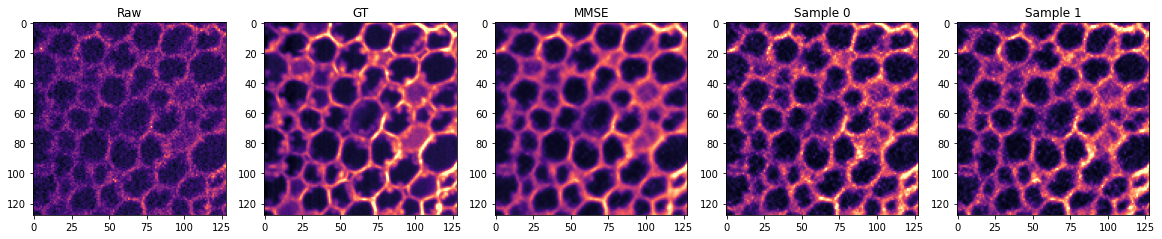

In [6]:
fig=plt.figure(figsize=(20, 10))
gt = signal[0][:128,:128]
vmin=np.percentile(gt,0)
vmax=np.percentile(gt,99)

columns = 5
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(observation[-1][:128,:128],cmap='magma')
plt.title("Raw")
fig.add_subplot(rows, columns, 2)
plt.imshow(gt,vmin=vmin, vmax=vmax,cmap='magma')
plt.title("GT")
fig.add_subplot(rows, columns, 3)
plt.imshow(img_mmse[:128,:128],vmin=vmin, vmax=vmax,cmap='magma')
plt.title("MMSE")
for i in range(4, columns*rows+1):
    img = samples[i][:128,:128]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,vmin=vmin, vmax=vmax,cmap='magma')
    plt.title("Sample "+str(i-4))
plt.show()